In [1]:
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister
import qiskit
from qiskit.circuit.library import QFT
import numpy as np
import operator

In [2]:
qiskit.__version__

'0.24.2'

Helpers

In [240]:
# def encode_integer(x, label):
#     '''Encode x in a quantum register
#     '''
#     num_bits = int(np.ceil(np.log2(x)))
#     qubit = QuantumRegister(num_bits, label)
#     return  

def encode_integers_and_setup_circuit(a: int, b: int, 
                                      verbose=False):
    '''Encode a & b and create classical c 
    '''
    # num bits required
    if a == 0 and b == 0:
        num_bits  = 1
    else:
        num_bits = 1 + int(np.log2(max(a, b)))
        
        if 1 + int(np.log2(a+b)) > num_bits:
            num_bits += 1 # quick fix 
        
    if verbose:
        print(f"#bits: {num_bits}")
    if num_bits > 32: 
        print('limited to 32 bits')
        return
    # num qu-bits
    qa = QuantumRegister(num_bits, 'a')
    qb = QuantumRegister(num_bits, 'b')
    # num classical-bits - maybe should add 1 more bit
    c_res = ClassicalRegister(num_bits, 'c')
    circuit = QuantumCircuit(qa, qb, c_res)
    # base 2   
    toBinary = lambda x: f"{x:0{num_bits}b}"
    a_base2 = toBinary(a)
    b_base2 = toBinary(b)
    # initialize qu-bits
    [circuit.x(qa[num_bits - 1 - i]) for i in range(num_bits) 
     if a_base2[i] == '1']         
    [circuit.x(qb[num_bits - 1 - i]) for i in range(num_bits) 
     if b_base2[i] == '1']
                            
    # apply QFT to the first n qubits
    circuit.append(QFT(num_bits, do_swaps=False), list(range(num_bits)))  #list(range(num_bits-1, -1, -1)))
    # counting in fourier space is adding a phase of  pi / 2**(#bits - k)
    #[[print(f"1/2^{j-k}, qb[{k}], qa[{j}]\n") 
    #        for k in range(j, -1, -1)] 
#     #           for j in range(num_bits-1, -1, -1)]                         
#     [[circuit.cp(np.pi/2**(j - k), qb[k], qa[j]) 
#       for k in range(j, -1, -1)] for j in range(num_bits-1, -1, -1)]                
    [[circuit.cp(np.pi/2**(j - k), qb[k], qa[j]) 
      for k in range(j, -1, -1)] for j in range(num_bits-1, -1, -1)] 

    # Inverse QFT
    circuit.append(QFT(num_bits, do_swaps=False).inverse(), list(range(num_bits)))  #list(range(num_bits-1, -1, -1)))                     
    #
    circuit.measure(qa, c_res)
    #
    if verbose:
        print(f'Expected result = b{toBinary(a + b)}')
    return qa, qb, c_res, circuit, toBinary(a + b)

In [265]:
def simulate(quantum_circuit, backend=None, shots=100):
    if backend is None:
        backend = Aer.get_backend('qasm_simulator')
    job = qiskit.execute(quantum_circuit, backend, shots=shots)
    result = job.result()
    #
    quantum_sum = max(result.get_counts().items(), key=operator.itemgetter(1))[0]
    print('-'* 21 + '\nQuantum sum = ', quantum_sum + '\n' +  '-'* 21)
    return result, quantum_sum

**Setup circuit**

In [266]:
qa, qb, c_res, circuit, correct_answer = encode_integers_and_setup_circuit(a=2, b=3, verbose=True)

#bits: 3
Expected result = b101


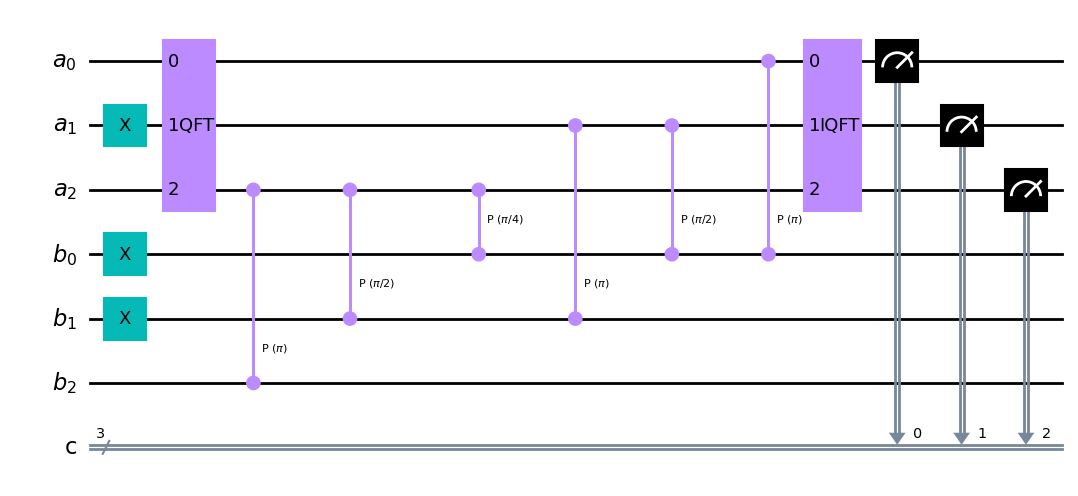

In [267]:
circuit.draw('mpl')

**Simulate QC**

In [268]:
res, quantum_sum = simulate(circuit, shots=100)
assert quantum_sum == correct_answer, 'Result Incorrect'

---------------------
Quantum sum =  101
---------------------


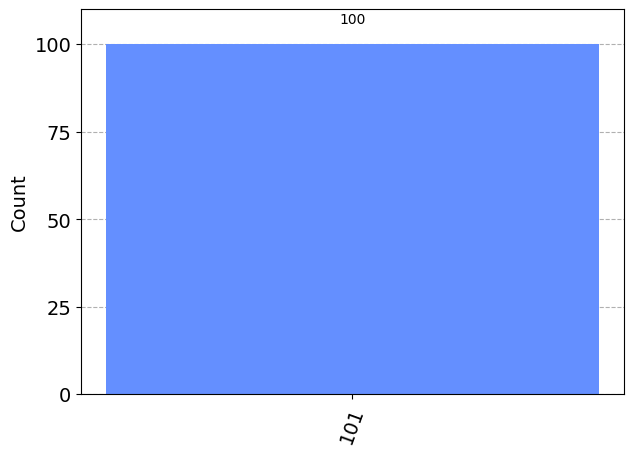

In [269]:
qiskit.visualization.plot_histogram(res.get_counts())

**Run on real Quantum Computer**

In [256]:
#%pip install qiskit-ibm-runtime

In [257]:
from qiskit import IBMQ
provider = IBMQ.load_account()

In [258]:
provider

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [271]:
backend = provider.get_backend('ibm_nairobi')
backend

<IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>

**Experiment 1**

In [273]:
res, quantum_sum = simulate(circuit, backend, shots=1024)
assert quantum_sum == correct_answer, 'Result Incorrect'

---------------------
Quantum sum =  001
---------------------


AssertionError: Result Incorrect

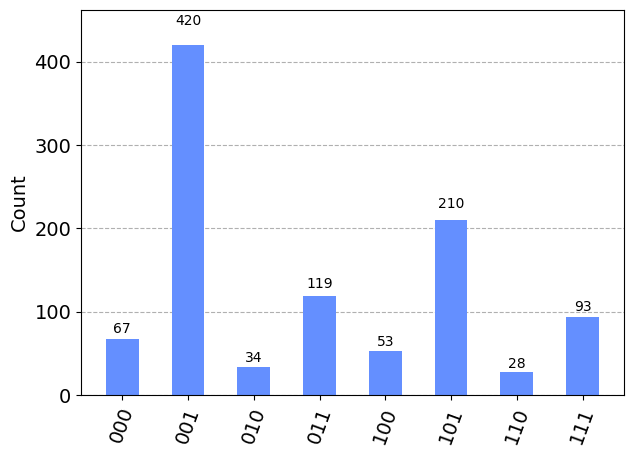

In [274]:
qiskit.visualization.plot_histogram(res.get_counts())

**Experiment 2**

In [275]:
res2, quantum_sum = simulate(circuit, backend, shots=1024)
assert quantum_sum == correct_answer, 'Result Incorrect'

---------------------
Quantum sum =  101
---------------------


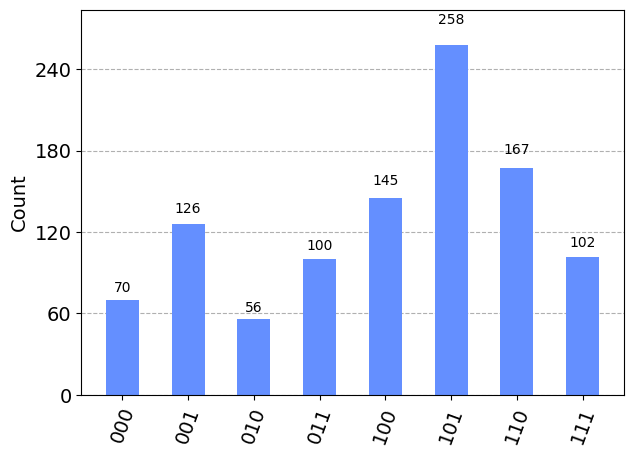

In [276]:
qiskit.visualization.plot_histogram(res2.get_counts())

**Experiment 3**

In [277]:
res2, quantum_sum = simulate(circuit, backend, shots=2*1024)
assert quantum_sum == correct_answer, 'Result Incorrect'

---------------------
Quantum sum =  001
---------------------


AssertionError: Result Incorrect

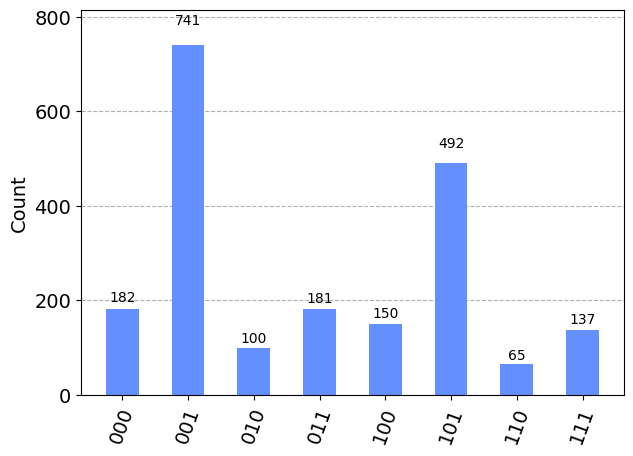

In [278]:
qiskit.visualization.plot_histogram(res2.get_counts())